## PROYECTO ANÁLISIS DE DEPRESIÓN PRINCIPALMENTE DE ESTUDIANTES EN INDIA

### FUENTE:
Tomando de Kaggle. URL: URL: https://www.kaggle.com/datasets/hopesb/student-depression-dataset

### METODOLOGÍA: 
Explicar la variable dicotómica de depresión (0:no, 1:sí). A partir de variables continuas y categóricas. Revisando supuestos para aplicar regresión lógistica y estadística bayesiana.  

In [7]:
## Importación librerias

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import pointbiserialr, chi2_contingency

In [2]:
## Lectura de datos 
datos = pd.read_csv(r"C:\Users\LENOVO\Desktop\Repositorio Github\Proyectos-Python\Proyecto_Depresion\Student Depression Dataset.csv")

# Ver las primeras filas
print(datos.head())
# Ver la estructura general: número de filas y columnas
print(datos.shape)
# Ver el tipo de datos por columna
print(datos.dtypes)
# Ver nombres de columnas
print(datos.columns)


   id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            0.0  8.97                 2.0               0.0   
1            0.0  5.90                 5.0               0.0   
2            0.0  7.03                 5.0               0.0   
3            0.0  5.59                 2.0               0.0   
4            0.0  8.13                 3.0               0.0   

      Sleep Duration Dietary Habits   Degree  \
0          5-6 hours        Healthy  B.Pharm   
1          5-6 hours       Moderate      BSc   
2  Less than 5 hours        Healthy       BA   
3          7-8

In [3]:
### Filtrado y manipulación tipo de datos

## Eliminar columnas no útiles para modelado
datos.drop(columns=["id"], inplace=True)

## Cambio tipo de datos - Mantuve númericas las que estaban bien y puse categóricas las que deben serlo
cols_a_categorizar = ['Gender', 'City', 'Profession', 'Academic Pressure',
                      'Work Pressure', 'Study Satisfaction', 'Job Satisfaction',
                      'Sleep Duration', 'Dietary Habits', 'Degree',
                      'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
                      'Financial Stress', 'Family History of Mental Illness', 'Depression']

datos[cols_a_categorizar] = datos[cols_a_categorizar].astype('category')

print("Verificación eliminación y cambio tipo de columnas de datos")
print(datos.dtypes)

## Verificación de no duplicidad en filas o columnas
filas_duplicadas = datos.duplicated()
columnas_duplicadas = datos.T.duplicated()
# Mostrar cuántas hay
print("\n")
print(f"Filas duplicadas: {filas_duplicadas.sum()}")
print(f"Filas duplicadas: {datos.columns[columnas_duplicadas]}")

## Revisar nulos
print("\n--- Valores nulos por columna ---")
print(datos.isnull().sum())


Verificación eliminación y cambio tipo de columnas de datos
Gender                                   category
Age                                       float64
City                                     category
Profession                               category
Academic Pressure                        category
Work Pressure                            category
CGPA                                      float64
Study Satisfaction                       category
Job Satisfaction                         category
Sleep Duration                           category
Dietary Habits                           category
Degree                                   category
Have you ever had suicidal thoughts ?    category
Work/Study Hours                         category
Financial Stress                         category
Family History of Mental Illness         category
Depression                               category
dtype: object


Filas duplicadas: 0
Filas duplicadas: Index([], dtype='object')

--- Valor

Ya que se cuenta con el dataframe sin datos duplicados, con el tipo de columnas requeridas y muy pocos valores nuelos. Se procede a hacer un análisis de los datos que hay en cada columna. Para ver si existe cierto sesgo hacia alguna categoría. Para ello:
* Se usarán **gráficos**. 
    * Gráficos de barras para las variables categóricas
    * Histogramas para las variables continuas**. 
* Se hará un primer análisis de **influencia** entre la variable de depresión contra las demás variables. Para ello:
    * Si la variable a analizar es numérica, se usará correlación point-biserial. 
    * Si la variable es categórica, se usará Cramér’s V (para más de 2 categorías) o también point-biserial si es binaria.

 

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17652\2328847991.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=datos, x=col, ax=ax, order=order, palette='pastel')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17652\2328847991.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=datos, x=col, ax=ax, order=order, palette='pastel')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17652\2328847991.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=datos, x=col, ax=ax, order=order, palette='pastel')
C:\Users\LENOVO\AppData\L

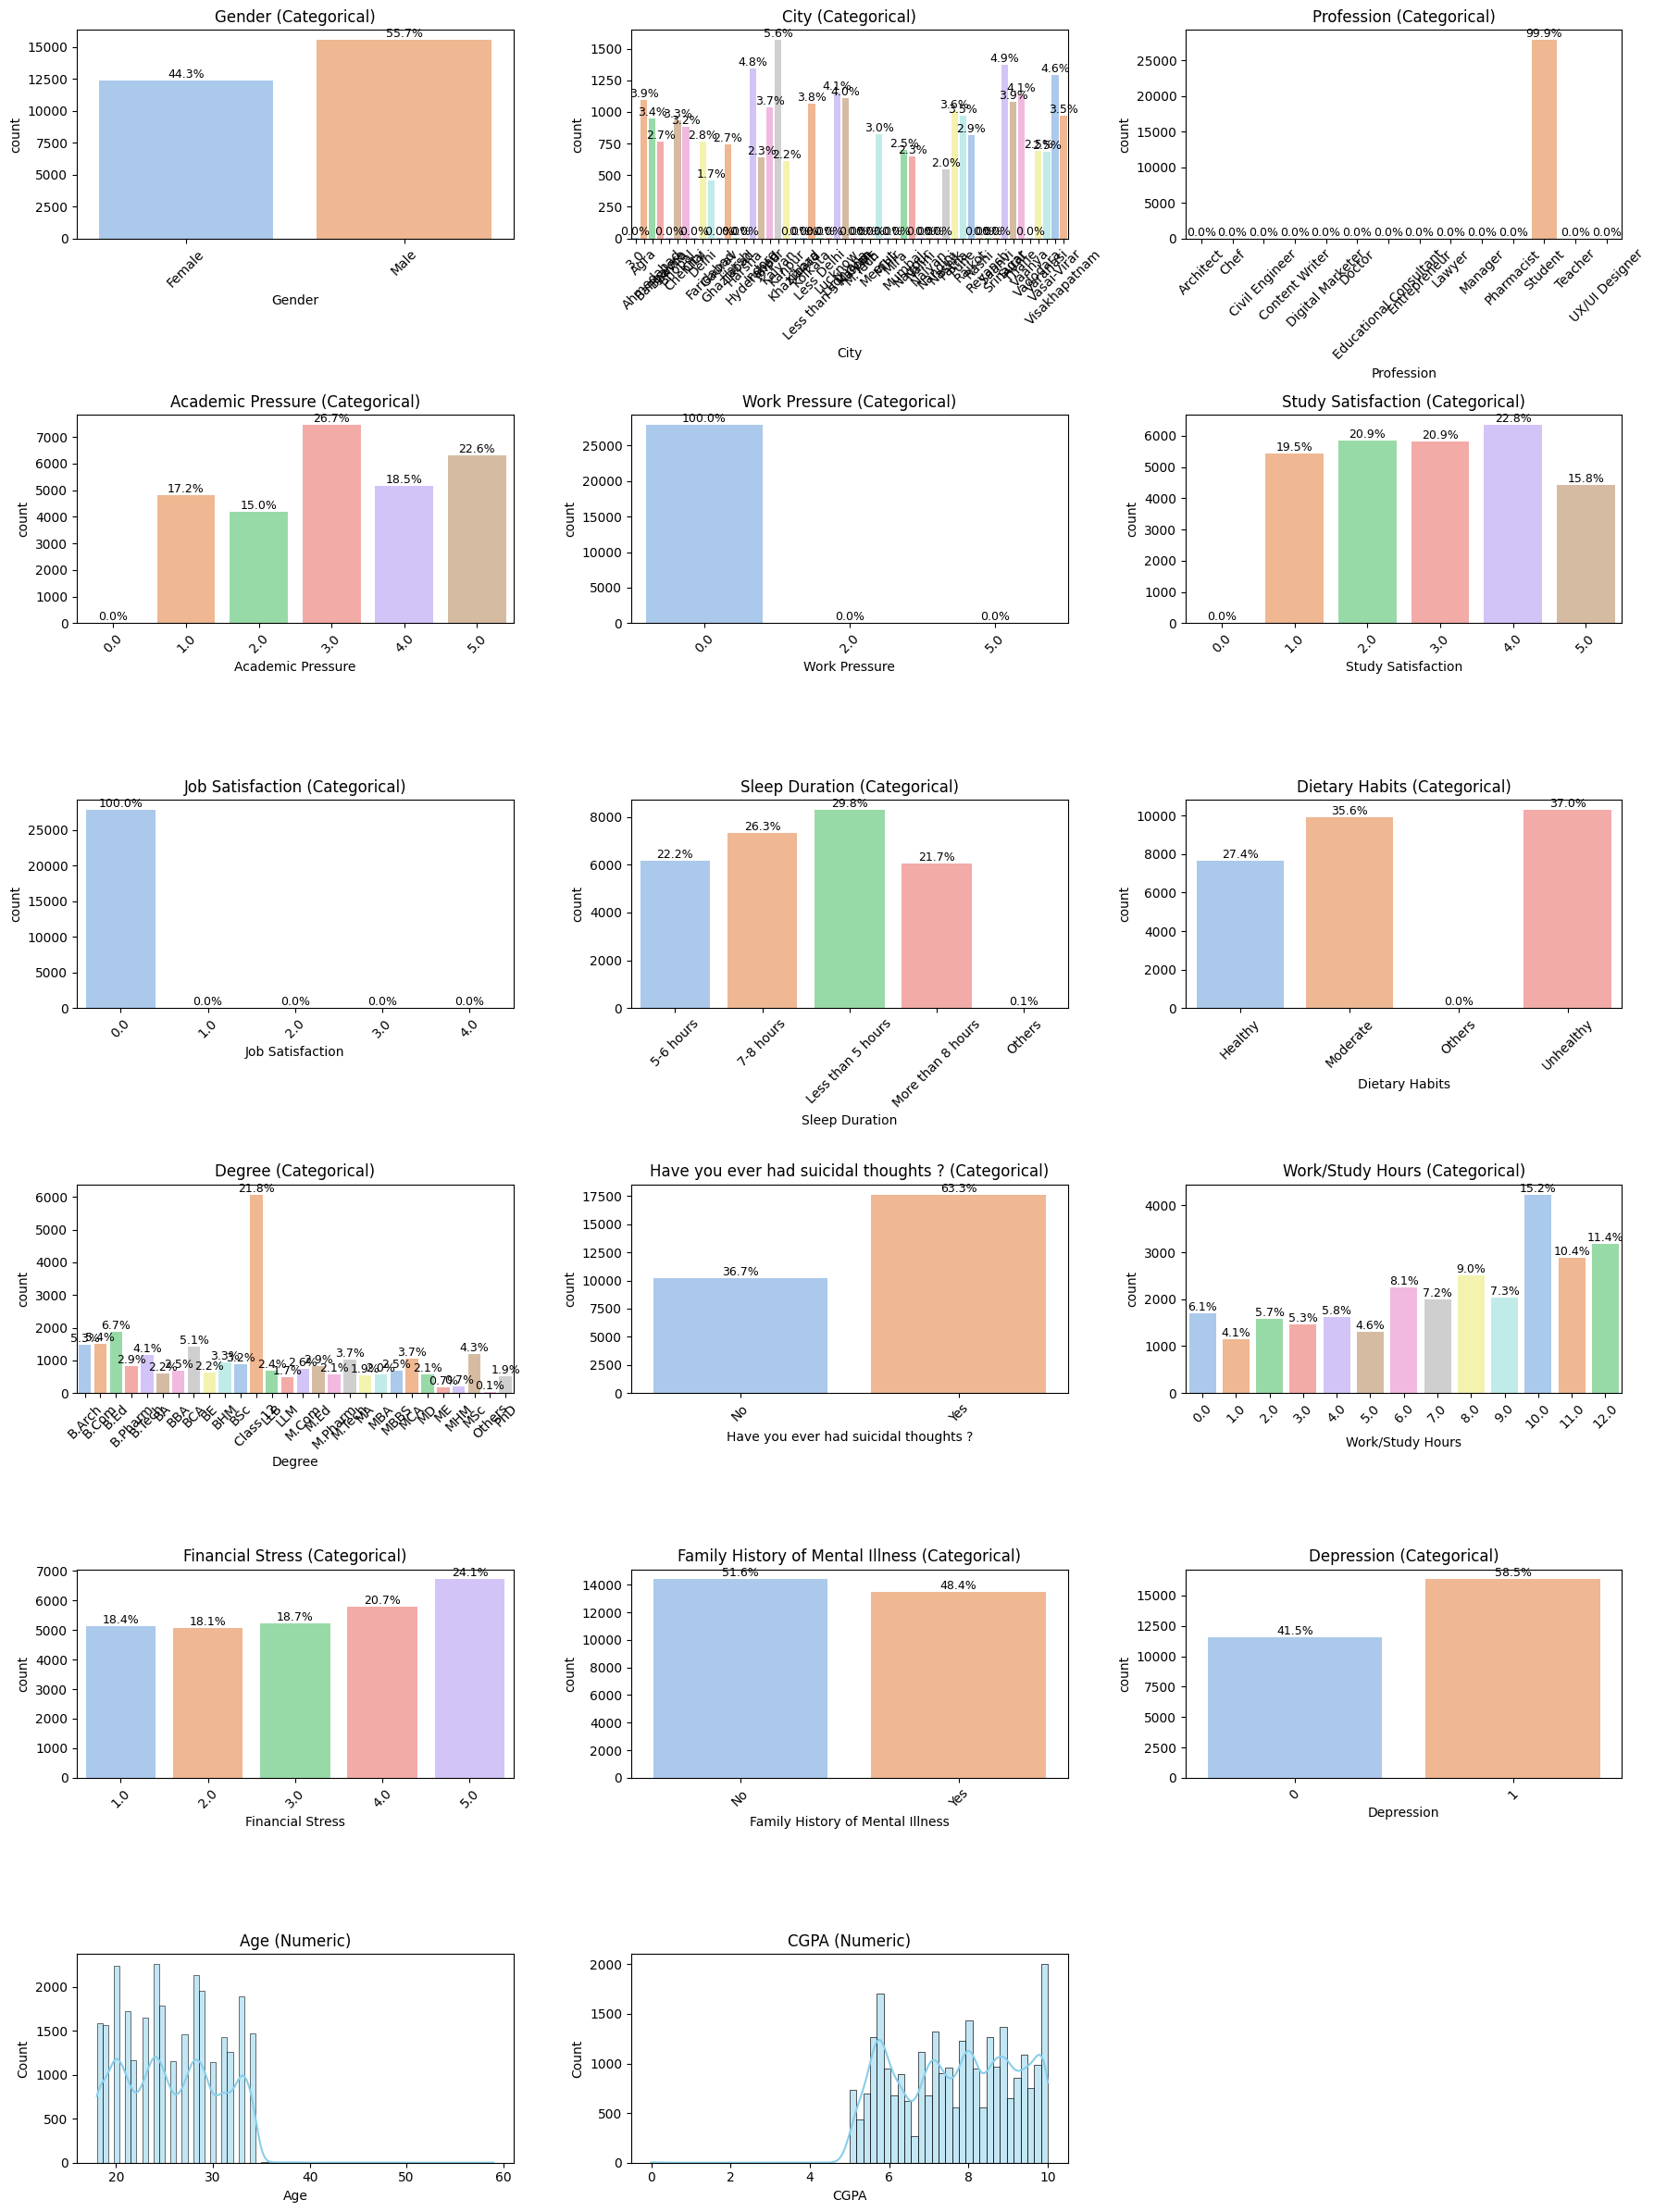

In [5]:
# --- Separar columnas por tipo ---
cat_cols = datos.select_dtypes(include='category').columns
num_cols = datos.select_dtypes(include='number').columns

# --- Total de columnas ---
total_cols = len(cat_cols) + len(num_cols)

# --- Tamaño de figura ---
cols = 3  # columnas por fila
rows = math.ceil(total_cols / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

# --- Gráficos para categóricas ---
for i, col in enumerate(cat_cols):
    ax = axes[i]
    order = datos[col].cat.categories
    total = len(datos[col])

    # Crear gráfico
    sns.countplot(data=datos, x=col, ax=ax, order=order, palette='pastel')

    # Añadir porcentaje encima de las barras
    for p in ax.patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        ax.annotate(f'{percentage:.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=9)

    ax.set_title(f"{col} (Categorical)")
    ax.tick_params(axis='x', rotation=45)

# --- Gráficos para numéricas ---
offset = len(cat_cols)
for j, col in enumerate(num_cols):
    ax = axes[offset + j]
    sns.histplot(data=datos, x=col, kde=True, ax=ax, color='skyblue')
    ax.set_title(f"{col} (Numeric)")

# --- Eliminar subplots vacíos ---
for k in range(total_cols, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

In [13]:
## Tal como se muestra, los datos de Work satisfactio y Job pressure, toman siempre valor de 0. Posiblemente debido a que la mayoría son estudiantes, por tal razón, se procede a eliminar las 3 columnas del dataframe. 
datos.drop(columns=["Profession", "Work Pressure", "Job Satisfaction"], inplace=True)

                                       Correlation with Depression  \
Have you ever had suicidal thoughts ?                        0.546   
Academic Pressure                                            0.480   
Financial Stress                                             0.364   
Work/Study Hours                                             0.215   
Dietary Habits                                               0.208   
Study Satisfaction                                           0.169   
Degree                                                       0.138   
Sleep Duration                                               0.100   
City                                                         0.082   
Family History of Mental Illness                             0.053   
CGPA                                                         0.022   
Gender                                                       0.002   
Age                                                         -0.226   

                   

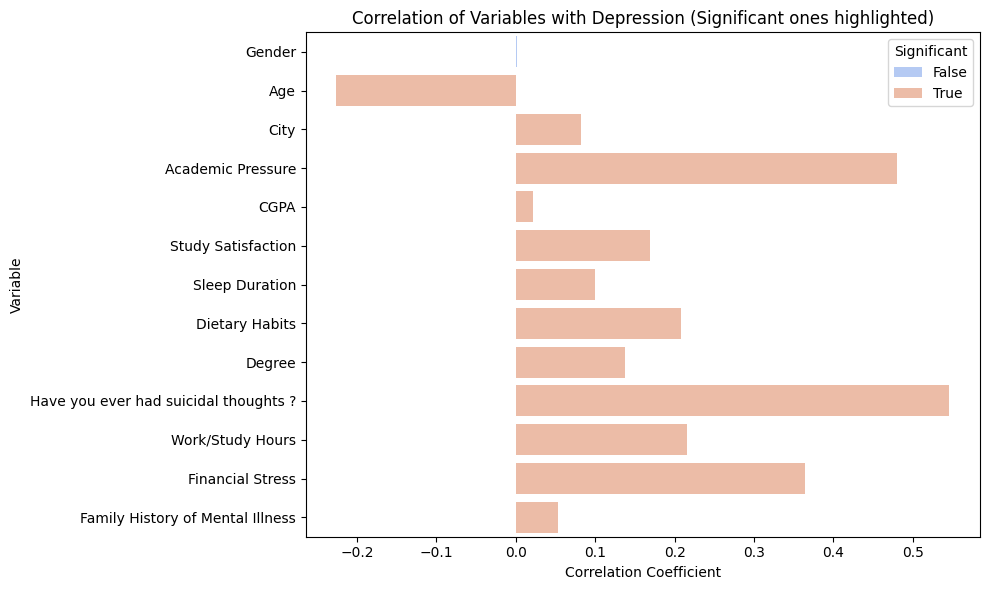

In [14]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p_value, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1)), p_value


# --- Resultados ---
resultados = {}
p_values = {}

for col in datos.columns:
    if col == 'Depression':
        continue
    if datos[col].dtype in ['float64', 'int64']:
        # Correlación numérica con binaria (Point-Biserial)
        coef, p_value = pointbiserialr(datos['Depression'], datos[col])
        resultados[col] = round(coef, 3)
        p_values[col] = p_value
    elif datos[col].dtype.name == 'category':
        # Correlación categórica con binaria (Cramér's V)
        coef, p_value = cramers_v(datos[col], datos['Depression'])
        resultados[col] = round(coef, 3)
        p_values[col] = p_value

# Convertir a DataFrame para visualización
res_df = pd.DataFrame.from_dict(resultados, orient='index', columns=['Correlation with Depression'])
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])

# Unir ambas tablas
final_df = pd.concat([res_df, p_values_df], axis=1)

# Filtrar los que son estadísticamente significativos (p < 0.05)
final_df['Significant'] = final_df['p-value'] < 0.05

# Mostrar resultados
print(final_df.sort_values(by='Correlation with Depression', ascending=False))

# (Opcional) Visualización de correlaciones significativas
plt.figure(figsize=(10, 6))
sns.barplot(x=final_df['Correlation with Depression'], y=final_df.index, hue=final_df['Significant'], palette='coolwarm')
plt.title("Correlation of Variables with Depression (Significant ones highlighted)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


En resumen, hay variables que sólo tomaban 1 valor posible, por lo cual, se eliminan. En adición, se realiza un análisi entre la variable depresión y las demás variables utilizando el coeficiente según su tipo, donde, también se realizó un análisis de significacia estadística tomando un valor p del 5%, con esto, se encontró que la variable género no tiene una alta importancia en si la persona sufre depresión o no. Sin embargo, parece que lo que más se relaciona es el hecho de tener presión acádemica y pensamientos suicidas. 